In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import matplotlib.pyplot as plt

# Build an Autoencoder for a human face dataset

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = '/Users/tiger/Downloads/lfw'

transform = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,), batch_size = 32, shuffle = True)

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS found.")
else:
    print ("MPS device not found.")

MPS found.


torch.Size([250, 250, 3])


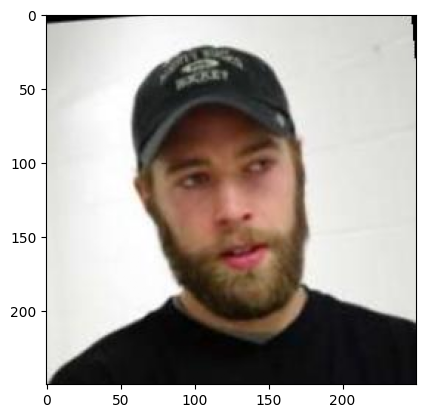

In [4]:
for x, y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [5]:
print(x.shape)

torch.Size([250, 250, 3])


The first two values represent the image's height and width (in pixels). The last value represents the number of channels (RGB).

# Step 3

Create a new pytorch model class for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [6]:
class AE(nn.Module):
    
    def __init__(self):
        super(AE,self).__init__()
        
        self.encodeLayers = nn.Sequential(
            nn.Conv2d(3, 32,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2),
            nn.Conv2d(32, 32,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2))
        
        self.decodeLayers = nn.Sequential(
            nn.ConvTranspose2d(32, 32,
                               kernel_size = 3, 
                               stride = 2, 
                               padding = 1, 
                               output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3,
                               kernel_size = 3, 
                               stride = 2, 
                               padding = 1, 
                               output_padding = 1),
            nn.BatchNorm2d(3),
            nn.Upsample(size = (250, 250)),
            nn.Sigmoid())

    def encoder(self, x):
        return self.encodeLayers(x)
        
    def decoder(self, x):
        return self.decodeLayers(x)
       
    def forward(self, x):
        e = self.encodeLayers(x)
        d = self.decodeLayers(e)
        
        return d

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [7]:
model = AE().to(device)

In [8]:
for image, label in dataloader:
    image = image.to(device)
    
    outputEncoded = model.encoder(image)
    outputDecoded = model.decoder(outputEncoded)

    print("Shape of encoder: ")
    print(outputEncoded.shape)

    print("Shape of decoder: ")
    print(outputDecoded.shape)

    break

Shape of encoder: 
torch.Size([32, 32, 62, 62])
Shape of decoder: 
torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [9]:
numParameters = 0

for p in model.parameters():
    elements = p.numel()
    numParameters += elements
    
print("Number of parameters: ", numParameters)

Number of parameters:  20265


In [10]:
loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-1)

Mean Squared Error (MSE) is appropriate for this task because it measures the difference between our input and output images. We want to minimize this value.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [11]:
num_epochs = 10

for epoch in range(num_epochs):
    totalLoss = 0.0
    
    for (img, _) in dataloader:
        originalImage = img.to(device)
        reconstructedImage = model(originalImage)
        
        loss = loss_function(reconstructedImage, originalImage)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalLoss += loss

    print("Epoch: ", epoch + 1, "Loss: ", totalLoss)

Epoch:  1 Loss:  tensor(2.7142, device='mps:0', grad_fn=<AddBackward0>)
Epoch:  2 Loss:  tensor(1.1209, device='mps:0', grad_fn=<AddBackward0>)
Epoch:  3 Loss:  tensor(0.9770, device='mps:0', grad_fn=<AddBackward0>)
Epoch:  4 Loss:  tensor(0.9069, device='mps:0', grad_fn=<AddBackward0>)
Epoch:  5 Loss:  tensor(0.8486, device='mps:0', grad_fn=<AddBackward0>)
Epoch:  6 Loss:  tensor(0.8745, device='mps:0', grad_fn=<AddBackward0>)
Epoch:  7 Loss:  tensor(0.8195, device='mps:0', grad_fn=<AddBackward0>)
Epoch:  8 Loss:  tensor(0.8360, device='mps:0', grad_fn=<AddBackward0>)
Epoch:  9 Loss:  tensor(0.8305, device='mps:0', grad_fn=<AddBackward0>)
Epoch:  10 Loss:  tensor(0.8256, device='mps:0', grad_fn=<AddBackward0>)


In the case that my loss was not decreasing, I would consider modifying the architecture of my autoencoder. Perhaps use some of the other layers that were suggested. I would perform more experimentation with their hyperparameters and also consider modifying the learning rate.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

<Figure size 1600x1200 with 0 Axes>

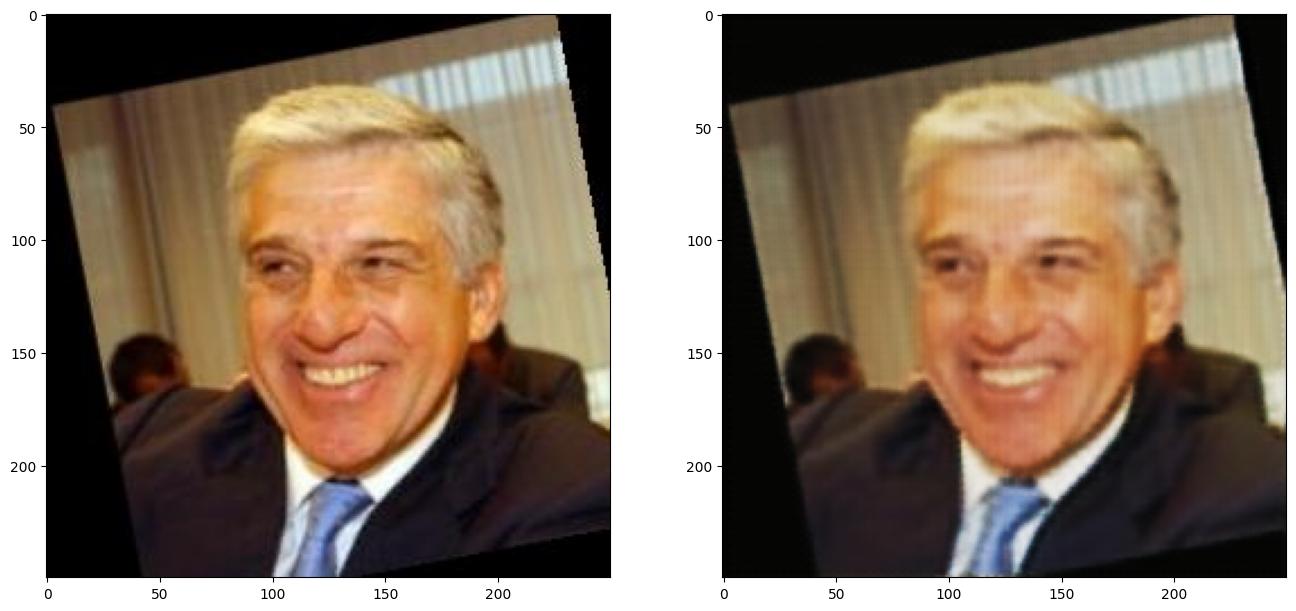

In [12]:
with torch.no_grad():
	for (image, _) in dataloader:
		image = image.to(device)
		reconstructedImage = model(image)
		break

plt.figure(dpi = 250)
fig, ax = plt.subplots(1, 2, figsize = (16, 16))

ax[0].imshow(image[1].cpu().numpy().transpose((1, 2, 0)))
ax[1].imshow(reconstructedImage[1].cpu().numpy().transpose((1, 2, 0)))

plt.show()

##  Step 8

In step 7, add a small normally distributed noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1600x1200 with 0 Axes>

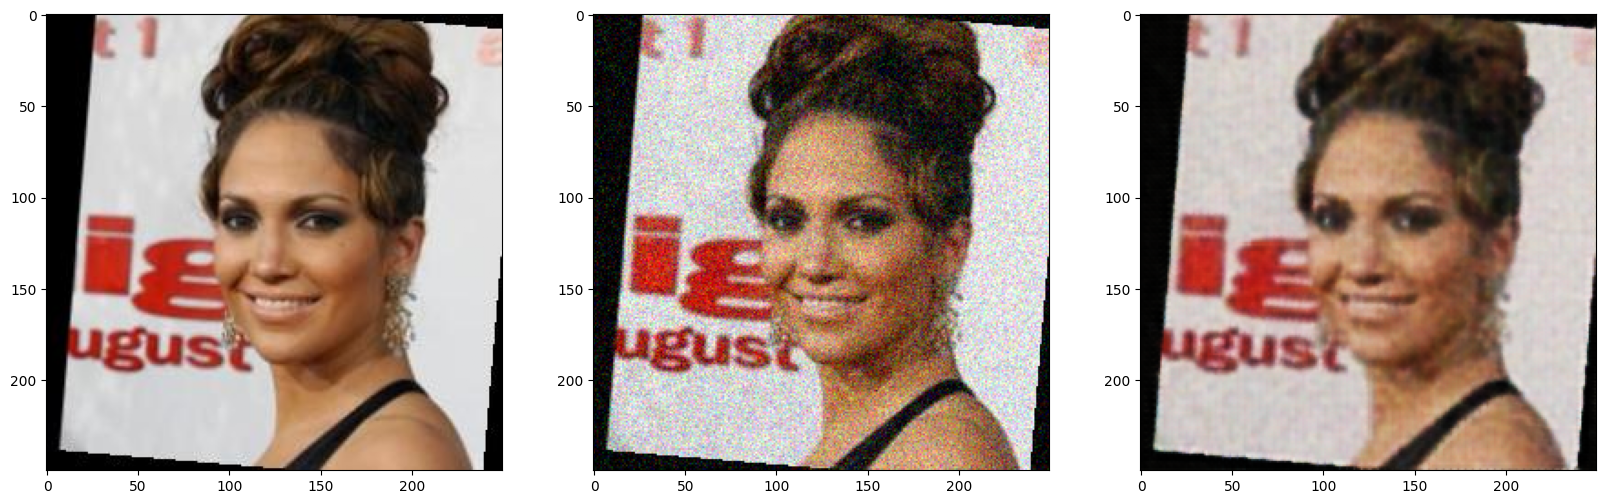

In [13]:
def add_noise(input):
    noise = torch.randn_like(input) * 0.1
    
    return input + noise

with torch.no_grad():
    for (image, _) in dataloader:
        image = image.to(device)
        noisyImage = add_noise(image).to(device)
        noisyImageDecoded = model(noisyImage)
        break

plt.figure(dpi = 250)
fig, ax = plt.subplots(1, 3, figsize = (20, 30))

ax[0].imshow(image[1].cpu().numpy().transpose((1, 2, 0)))
ax[1].imshow(noisyImage[1].cpu().numpy().transpose((1, 2, 0)))
ax[2].imshow(noisyImageDecoded[1].cpu().numpy().transpose((1, 2, 0)))

plt.show()

Adding noise results in a noticeably blurrier image. The input image has been partially corrupted by the noise, so the model produces a less accurate image.